### Project Setup and Library Installation

This section sets up the Python environment by installing necessary packages and importing all essential libraries needed for data analysis, visualization, clustering, and preprocessing.


In [2]:
# Install required library
!pip install textblob

# Importing basic libraries
import pandas as pd
import numpy as np
from textblob import TextBlob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

We have 8 different CSV files, and each one holds a different kind of info.  
We’re loading them all into Python so that we can clean, combine, and use them to understand customer behavior.

Here’s what each file is about and why it matters:

- **Customers.csv** → Basic info about each customer (like ID, gender, location, etc.). We'll use it to match customer IDs across other files.
- **Transaction.csv** → All purchase records (amount, date, product, customer ID). This is our main source for figuring out how customers shop.
- **Products.csv** → Info about each product (price, category, etc.). Useful for understanding what’s being bought.
- **Coupon.csv** → List of coupons that were issued. Helps us track who got what discounts.
- **Redemption.csv** → Tells us which coupons were actually used. We'll use this to see who responds to offers.
- **Feedbacks.csv** → Customer ratings and reviews. We’ll use this for sentiment analysis to check if people are happy or not.
- **Employee.csv** → Details about the employees (not used directly in clustering, but could be used for future analysis).
- **Supplier.csv** → Info on product suppliers (not directly used, but helps give background about products).

We’ll load all these into separate DataFrames using pandas.


In [4]:
# Load all CSVs (make sure they're in the same folder as the notebook)
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transaction.csv")
products_df = pd.read_csv("Products.csv")
feedbacks_df = pd.read_csv("Feedbacks.csv")
coupon_df = pd.read_csv("Coupon.csv")
redemption_df = pd.read_csv("Redemption.csv")
supplier_df = pd.read_csv("Supplier.csv")
employee_df = pd.read_csv("Employee.csv")

### Creating the Final Customer Dataset (RFM, Sentiment, Coupons, Products)

In this part, we're building a complete picture of every customer by mixing info from different files.  

We're making 4 types of features:

- **RFM features** (Recency, Frequency, Monetary) from `Transaction.csv`
- **Sentiment and Ratings** from `Feedbacks.csv`
- **Coupon usage** from `Redemption.csv`
- **Product engagement** from `Transaction.csv` + `Products.csv`

Let’s break it down 

---

#### RFM Features (from Transactions)

- **Recency** = How many days ago the customer last bought something  
- **Frequency** = Total number of purchases  
- **Monetary** = Total amount they spent

We calculate this using `PurchaseDate`, `TransactionID`, and `PurchaseAmount`.

---

#### Sentiment & Ratings (from Feedbacks)

We use **TextBlob** to convert customer feedback into a **sentiment score** (from -1 to +1).  
Then we group it by customer and take their average **rating** and **sentiment score**.

---

#### Coupon Usage (from Redemption)

We look at:
- How many coupons a customer has used  
- What’s the average discount they got  

We also rename `CustomerID` to match the rest of the files.

---

#### Product Engagement (from Transactions + Products)

Here we check:
- How many **unique product categories** a customer has shopped from  
- Their **total spend** (Quantity × Price)  
- Total number of products they bought

---

#### Final Merge (Everything Combined)

We now merge all the features using `Customer-ID`:
- RFM + Ratings + Sentiment + Coupons + Product Stats  
If someone doesn't have data in one area (like no feedback), we fill it with 0.

The final output `full_features_df` is our **complete dataset for clustering**.

Each row = one customer  
Each column = one behavior feature


In [6]:
# RFM from Transaction.csv
transactions_df['PurchaseDate'] = pd.to_datetime(transactions_df['PurchaseDate'])
snapshot_date = transactions_df['PurchaseDate'].max() + pd.Timedelta(days=1)

rfm_df = transactions_df.groupby('Customer-ID').agg({
    'PurchaseDate': lambda x: (snapshot_date - x.max()).days,
    'TransactionID': 'count',
    'PurchaseAmount': 'sum'
}).reset_index()

rfm_df.columns = ['Customer-ID', 'Recency', 'Frequency', 'Monetary']

# -----------------------------
# Feedback Sentiment from Feedbacks.csv
def get_sentiment(text):
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return 0.0

feedbacks_df['SentimentScore'] = feedbacks_df['Feedback'].apply(get_sentiment)

sentiment_df = feedbacks_df.groupby('Customer-ID').agg({
    'Ratings': 'mean',
    'SentimentScore': 'mean'
}).reset_index()

# -----------------------------
# Coupon Usage from Redemption.csv
coupon_usage_df = redemption_df.groupby('CustomerID').agg({
    'UsedCouponID': 'count',
    'DiscountAmount': 'mean'
}).reset_index()

# Rename CustomerID to match other tables
coupon_usage_df.rename(columns={'CustomerID': 'Customer-ID'}, inplace=True)
coupon_usage_df.columns = ['Customer-ID', 'CouponsUsed', 'AvgDiscount']

# -----------------------------
# Product Engagement
transaction_products = transactions_df.merge(
    products_df[['ProductID', 'Categories', 'Prices']],
    on='ProductID',
    how='left'
)

transaction_products['TotalSpend'] = transaction_products['PurchaseQuantity'] * transaction_products['Prices']

product_engagement_df = transaction_products.groupby('Customer-ID').agg({
    'Categories': pd.Series.nunique,
    'TotalSpend': 'sum',
    'PurchaseQuantity': 'sum'
}).reset_index()

product_engagement_df.columns = ['Customer-ID', 'CategoryDiversity', 'TotalCategorySpend', 'TotalQuantity']

# -----------------------------
# Merge all features
full_features_df = rfm_df \
    .merge(sentiment_df, on='Customer-ID', how='left') \
    .merge(coupon_usage_df, on='Customer-ID', how='left') \
    .merge(product_engagement_df, on='Customer-ID', how='left')

full_features_df.fillna(0, inplace=True)

### Scaling the Data Before Clustering

Now that we’ve created all the customer features (like Recency, Frequency, Ratings, Spend, etc.), we need to scale them.

Why?

Because some features like "Total Spend" can have huge values, while others like "Sentiment Score" are small.  
Without scaling, algorithms like KMeans might give more importance to the bigger numbers.

So we use StandardScaler to bring all features to the same level — it standardizes the values so that the mean is 0 and the standard deviation is 1.

---

#### What this block does:

1. Drops the `Customer-ID` column (because it's just an identifier, not useful for clustering)
2. Uses StandardScaler from sklearn to scale all the numeric features
3. Stores the final scaled result in `X_scaled`, which will be used for clustering


In [8]:
from sklearn.preprocessing import StandardScaler

# Drop the Customer-ID before scaling
X = full_features_df.drop(columns=['Customer-ID'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Defining a Function to Summarize Clusters

After running a clustering algorithm, we need to understand what each cluster actually looks like.  
This function `summarize_clusters()` helps with that. It gives a simple summary for each cluster by:

- Calculating the average value of each numeric feature for every cluster
- Showing those values in a table
- Plotting a bar chart to visually compare clusters

---

#### What this function does step by step:

1. Makes a copy of the input data so the original DataFrame isn't changed.
2. Adds a new column with the cluster labels.
3. Selects only numeric columns to use for summary (ignores text columns like names or IDs).
4. If any cluster label is `-1` (which means noise in DBSCAN or HDBSCAN), it removes those rows.
5. Groups the data by cluster label and calculates the mean for each numeric column.
6. Displays the summary table.
7. Selects key features like Recency, Frequency, etc. and shows a bar plot to compare the clusters side by side.

This function works with all clustering methods like KMeans, DBSCAN, GMM, HDBSCAN, etc. and helps you describe each group based on real customer behavior.


In [34]:
def summarize_clusters(df, labels, label_name):
    """
    Create and plot a summary of numeric features by cluster.
    """
    import matplotlib.pyplot as plt

    temp = df.copy()
    temp[label_name] = labels

    # Keep only numeric columns
    numeric_cols = temp.select_dtypes(include='number').columns.tolist()
    if label_name in numeric_cols:
        numeric_cols.remove(label_name)

    # Remove noise points (-1) if they exist
    if -1 in temp[label_name].values:
        temp = temp[temp[label_name] != -1]

    # Get cluster-wise averages
    summary = temp.groupby(label_name)[numeric_cols].mean().round(2)

    # Show table
    print(f"\n📊 {label_name} Cluster Summary:")
    display(summary)

    # Bar chart for key features
    features_to_plot = ['Recency', 'Frequency', 'Monetary', 'Ratings', 'SentimentScore']
    features_to_plot = [f for f in features_to_plot if f in summary.columns]

    summary[features_to_plot].T.plot(kind='bar', figsize=(10,6))
    plt.title(f"{label_name} - Feature Comparison")
    plt.ylabel("Average Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

### Finding the Best Number of Clusters Using the Elbow Method

Before applying KMeans, we need to choose how many clusters (groups) we want.  
We can’t just guess — instead, we use a method called the **Elbow Method** to find the best value for `k` (number of clusters).

---

#### What this code does:

1. Runs KMeans for different values of k (from 2 to 10)
2. For each k, it calculates **WCSS** — which is the total distance between each point and its cluster center
3. Plots these WCSS values to show how the error decreases as we increase k

---

### What the chart means:

That point where the curve **bends or levels off** is called the "**elbow**" — and it usually indicates the **best number of clusters**.
In this graph, the elbow looks around **k = 4**, which means 4 is a good number of clusters to use in KMeans.


C:\Users\navne\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\navne\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\navne\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\navne\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\navne\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

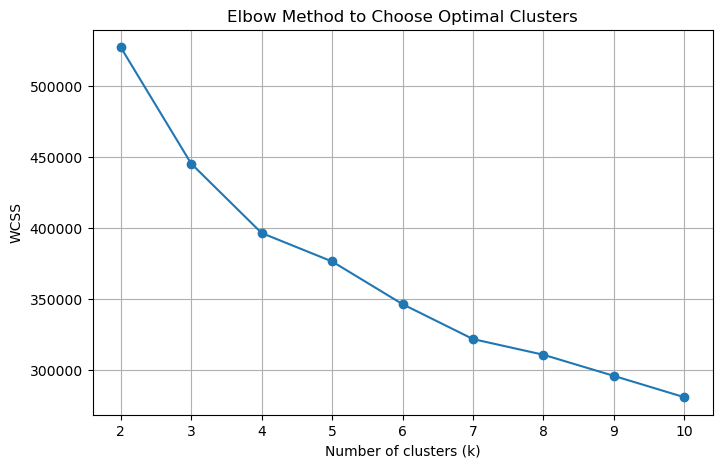

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []  # Within-Cluster Sum of Squares

# Try cluster sizes from 2 to 10
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8,5))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method to Choose Optimal Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

### Applying K-Means Clustering (k = 4)

After finding the best number of clusters using the Elbow Method (which was 4), we now apply KMeans with `k=4`.

---

#### What this block does:

1. **Fits the KMeans model** on the scaled dataset using 4 clusters.
2. **Calculates the Silhouette Score**, which measures how well the points are grouped.  
   - Score range is from -1 to 1.  
   - Higher value means better-defined clusters.
3. **Reduces the data to 2 dimensions** using PCA (Principal Component Analysis) for easier visualisation.
4. **Creates a scatter plot** using Seaborn, with points colored by their cluster.

---

#### Result and Interpretation:

- **Silhouette Score**: `0.190`  
  This is a moderate score. It shows that the clusters are somewhat distinguishable but not very well separated. It’s not bad, but not excellent either.

- **Plot**:  
  From the scatter plot, we can see 4 different clusters are formed, with varying densities.  
  Cluster 2 (green) seems to be the largest and most compact, while Clusters 0, 1, and 3 are smaller.

This result helps us understand how the customers are naturally grouped based on their behavior.

We can now use this output for further analysis, like summarizing what each cluster represents using `summarize_clusters()`.


Silhouette Score (K-Means, k=4): 0.190


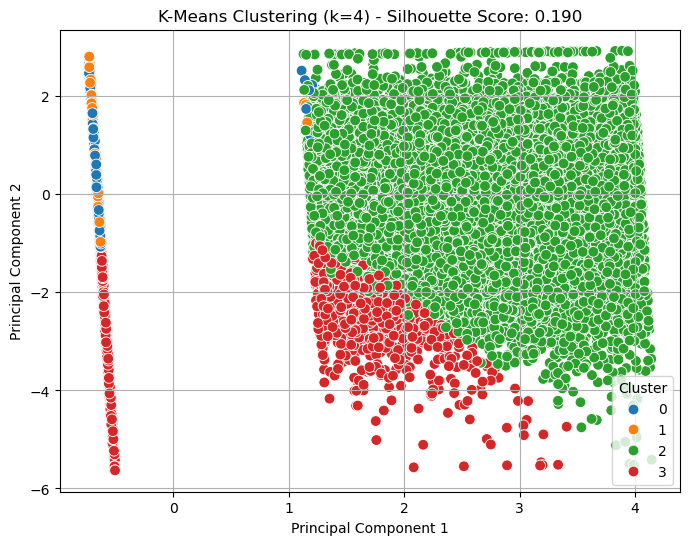

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Fit the KMeans model
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Silhouette Score
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
print(f"Silhouette Score (K-Means, k=4): {kmeans_silhouette:.3f}")

# Visualize Clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans_plot_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
kmeans_plot_df['Cluster'] = kmeans_labels

plt.figure(figsize=(8,6))
sns.scatterplot(data=kmeans_plot_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
plt.title(f'K-Means Clustering (k=4) - Silhouette Score: {kmeans_silhouette:.3f}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()



📊 KMeans Cluster Summary:


,Recency,Frequency,Monetary,Ratings,SentimentScore,CouponsUsed,AvgDiscount,CategoryDiversity,TotalCategorySpend,TotalQuantity
KMeans,,,,,,,,,,
0,1268.32,1.0,401.13,4.74,0.29,0.00,0.01,0.0,0.0,13.13
1,1282.26,1.0,1208.50,4.73,0.29,0.00,0.01,0.0,0.0,12.84
2,1271.81,1.0,807.01,4.30,0.25,1.00,104.98,0.0,0.0,13.02
3,1289.77,1.0,801.68,1.72,0.02,0.05,2.11,0.0,0.0,13.03


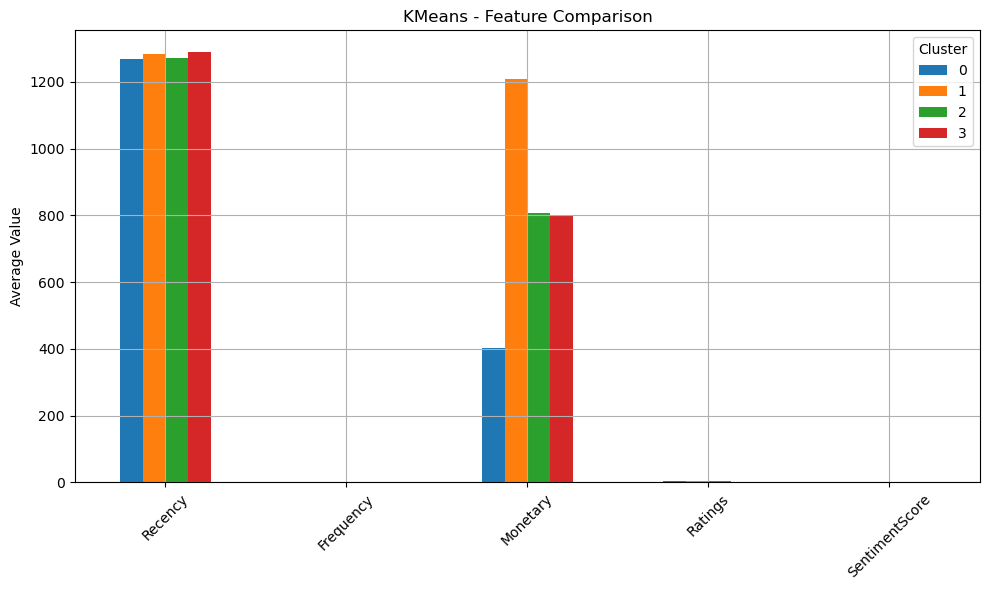

In [36]:
summarize_clusters(full_features_df, kmeans_labels, 'KMeans')

###  K-Means Cluster Profile Summary

| Cluster | Label                    | Key Traits                                                                 | Action Suggestion                              |
|---------|--------------------------|-----------------------------------------------------------------------------|------------------------------------------------|
| 0       | Passive One-Timers       | Low spend (401), high recency (~1268 days), high satisfaction (4.74), no coupon usage, low diversity | Re-engage with personalized offers             |
| 1       | Big Spenders (One-Time)  | Very high spend (1208), high satisfaction (4.73), no coupon usage, long inactive | VIP loyalty or premium reactivation strategy   |
| 2       | Coupon-Lovers            | Medium spend (807), used coupons (avg discount: 105), decent feedback, no diversity | Continue discount campaigns, upsell bundles   |
| 3       | Low Satisfaction Buyers  | Moderate spend (801), very low rating (1.72), low sentiment (0.02), slight diversity | Target with service recovery or feedback follow-up |


### Applying Agglomerative Clustering on a Sample of 10,000 Customers

Agglomerative Clustering is a type of hierarchical clustering.  
It works by treating each data point as its own cluster at first, and then slowly merging the closest pairs until only the desired number of clusters are left.

Since it's computationally heavy, we apply it to a **sample of 10,000 records** (instead of the full dataset).

---

#### What this code does:

1. **Samples 10,000 rows** from the scaled dataset using `resample`  
   This makes it faster and avoids memory issues.
2. Applies **Agglomerative Clustering** with 4 clusters.
3. Calculates the **Silhouette Score** to check the quality of clusters.
4. Uses **PCA** to reduce data to 2D and **plots** the clusters with different colors.

---

#### Result and Interpretation:

- **Silhouette Score**: `0.149`  
  This is slightly lower than the KMeans score (which was 0.190), meaning the clusters are a bit less defined here.
  
- **Plot Observation**:  
  In the scatter plot, we can see that cluster separation isn’t very strong.  
  Some clusters (like Cluster 3) dominate most of the space, and the rest are tightly packed.

This method still gives some structure, but it's not as clean as KMeans in this case.


Silhouette Score (Agglomerative, n=10k): 0.149


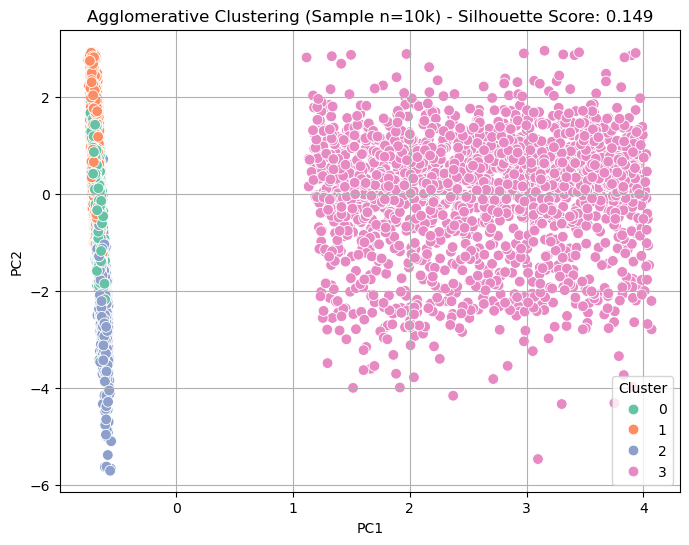

In [16]:
# Sample 10,000 records for hierarchical clustering
from sklearn.utils import resample

X_sample, labels_sample = resample(X_scaled, kmeans_labels, n_samples=10000, random_state=42)

# Apply Agglomerative on the sample
agglo_model = AgglomerativeClustering(n_clusters=4)
agglo_labels = agglo_model.fit_predict(X_sample)

# Evaluate
agglo_silhouette = silhouette_score(X_sample, agglo_labels)
print(f"Silhouette Score (Agglomerative, n=10k): {agglo_silhouette:.3f}")

# Visualize
pca_agglo = PCA(n_components=2).fit_transform(X_sample)
plot_df_agglo = pd.DataFrame(pca_agglo, columns=['PC1', 'PC2'])
plot_df_agglo['Cluster'] = agglo_labels

plt.figure(figsize=(8,6))
sns.scatterplot(data=plot_df_agglo, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=60)
plt.title(f'Agglomerative Clustering (Sample n=10k) - Silhouette Score: {agglo_silhouette:.3f}')
plt.grid(True)
plt.show()


📊 Agglomerative Cluster Summary:


,Recency,Frequency,Monetary,Ratings,SentimentScore,CouponsUsed,AvgDiscount,CategoryDiversity,TotalCategorySpend,TotalQuantity
Agglomerative,,,,,,,,,,
0,1248.03,1.0,1082.63,4.59,0.23,0.0,0.00,0.0,0.0,13.53
1,1329.09,1.0,480.35,4.75,0.35,0.0,0.00,0.0,0.0,12.09
2,1213.30,1.0,763.29,1.56,0.04,0.0,0.00,0.0,0.0,13.08
3,1282.61,1.0,815.22,4.14,0.24,1.0,101.95,0.0,0.0,13.12


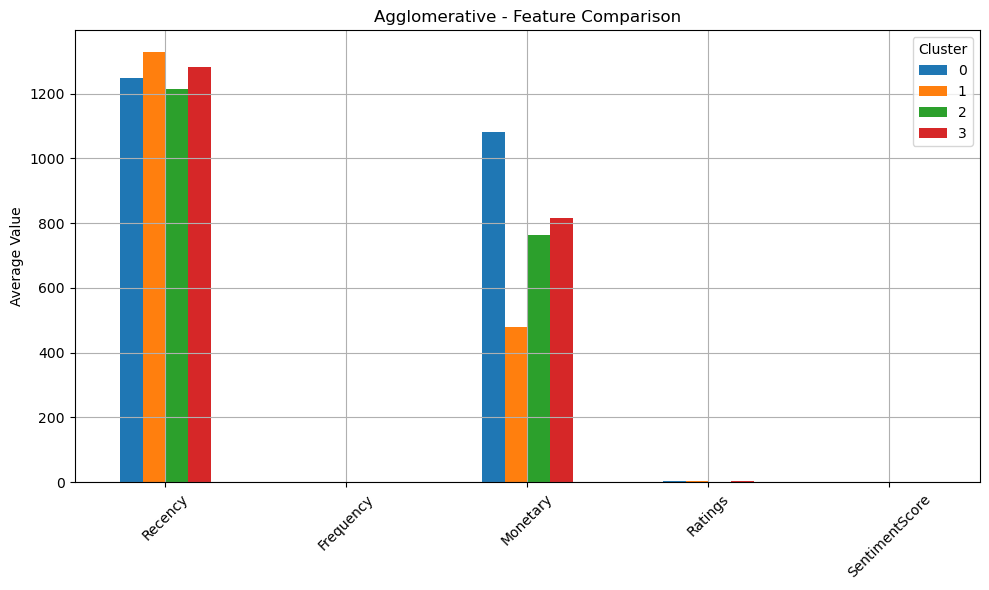

In [48]:
agglo_sample = resample(full_features_df, n_samples=10000, random_state=42)
summarize_clusters(agglo_sample, agglo_labels, 'Agglomerative')

###  Agglomerative Clustering – Cluster Profile Summary

| Cluster | Label                    | Key Traits                                                                 | Action Suggestion                              |
|---------|--------------------------|-----------------------------------------------------------------------------|------------------------------------------------|
| 0       | Premium Inactive Buyers  | High spend (1082), inactive (Recency ~1248), decent rating (4.59), no discounts used | Retarget with exclusive benefits or loyalty program |
| 1       | Happy Light Shoppers     | Low spend (480), very high rating (4.75), long inactive (1329), no coupon usage | Encourage return with personalized product recos |
| 2       | Dissatisfied Buyers      | Moderate spend (763), very low rating (1.56), low sentiment (0.04), no discount usage | Launch service recovery or feedback campaigns |
| 3       | Coupon-Savvy Spenders    | Decent spend (815), good rating (4.14), used coupons (avg discount: 101.95), slight diversity | Promote bundled offers, product diversity push |


### Applying DBSCAN Clustering on a Sample of 10,000 Records

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering method that doesn't require us to choose the number of clusters in advance.  
Instead, it groups data points based on density — meaning it finds areas with many points close together.

It also automatically marks **noise points** (outliers) which don’t fit into any cluster.

---

#### What this code does:

1. Samples **10,000 records** from the full dataset to avoid performance issues.
2. Runs **DBSCAN** with:
   - `eps=1.2`: max distance between two points to be considered neighbors
   - `min_samples=10`: minimum number of points to form a dense region
3. Calculates the **number of clusters** (excluding noise labeled as -1).
4. Calculates the **Silhouette Score** to evaluate cluster quality (only if there are at least 2 clusters).
5. Uses **PCA** to reduce the dimensions and plots the clusters using Seaborn.

---

#### Result and Interpretation:

- **Estimated Clusters**: 4 (excluding noise)
- **Silhouette Score**: `0.254`

This is a better score than both Agglomerative and KMeans, which means the clusters formed by DBSCAN are more well-defined and separated.

- **Noise Points**:  
  All the points labeled as `-1` in the plot are noise or outliers that DBSCAN decided not to include in any cluster.  
  This is useful for identifying unusual or less active customers.

The plot shows a good separation between clusters, especially Cluster 1 and Cluster 0. DBSCAN is great when the data has a mix of dense areas and outliers.


DBSCAN: Estimated Clusters (excluding noise): 4
Silhouette Score (DBSCAN): 0.254


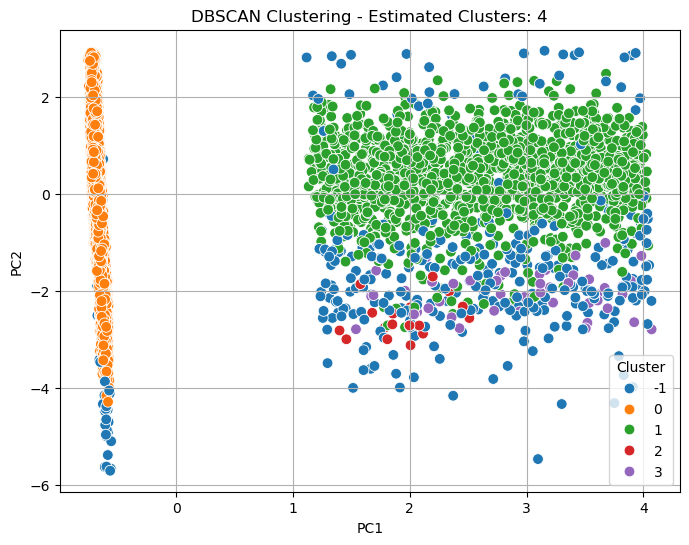

In [20]:
from sklearn.cluster import DBSCAN
from sklearn.utils import resample

# Sample 10k rows
X_dbscan_sample = resample(X_scaled, n_samples=10000, random_state=42)

# Apply DBSCAN
dbscan = DBSCAN(eps=1.2, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_dbscan_sample)

# Estimate number of clusters (excluding noise)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"DBSCAN: Estimated Clusters (excluding noise): {n_clusters}")

# Silhouette Score
if n_clusters > 1:
    dbscan_silhouette = silhouette_score(X_dbscan_sample, dbscan_labels)
    print(f"Silhouette Score (DBSCAN): {dbscan_silhouette:.3f}")
else:
    print("Too few clusters to calculate Silhouette Score")

# Visualize
pca_dbscan = PCA(n_components=2).fit_transform(X_dbscan_sample)
plot_df_dbscan = pd.DataFrame(pca_dbscan, columns=['PC1', 'PC2'])
plot_df_dbscan['Cluster'] = dbscan_labels

plt.figure(figsize=(8,6))
sns.scatterplot(data=plot_df_dbscan, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
plt.title(f'DBSCAN Clustering - Estimated Clusters: {n_clusters}')
plt.grid(True)
plt.show()


📊 DBSCAN Cluster Summary:


,Recency,Frequency,Monetary,Ratings,SentimentScore,CouponsUsed,AvgDiscount,CategoryDiversity,TotalCategorySpend,TotalQuantity
DBSCAN,,,,,,,,,,
0,1272.63,1.0,811.53,4.19,0.25,0.0,0.00,0.0,0.0,12.93
1,1274.99,1.0,808.74,4.62,0.27,1.0,102.27,0.0,0.0,13.09
2,1987.44,1.0,1163.83,1.11,-0.07,1.0,52.50,0.0,0.0,20.78
3,1062.29,1.0,785.25,1.38,0.05,1.0,120.44,0.0,0.0,8.13


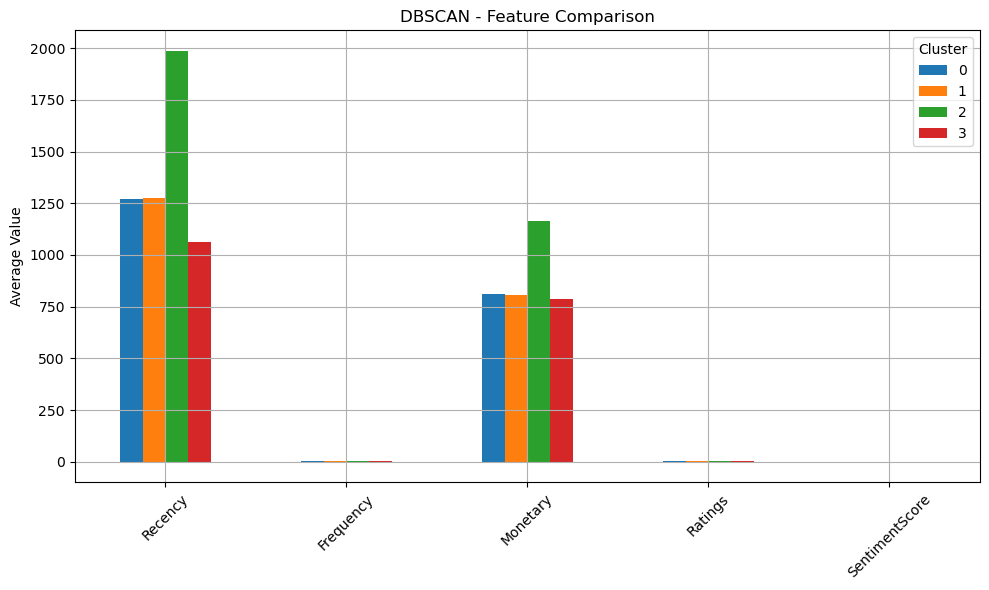

In [40]:
dbscan_sample = resample(full_features_df, n_samples=10000, random_state=42)
summarize_clusters(dbscan_sample, dbscan_labels, 'DBSCAN')

###  DBSCAN Cluster Profile Summary

| Cluster | Label                   | Key Traits                                                                 | Action Suggestion                                  |
|---------|-------------------------|-----------------------------------------------------------------------------|----------------------------------------------------|
| 0       | Steady Buyers           | Good spend (812), neutral sentiment (0.25), fair ratings (4.19), no discounts | Promote loyalty program or personalized deals      |
| 1       | Satisfied Coupon Users  | Moderate spend (809), good sentiment (0.27), used coupons (102 avg discount) | Encourage further coupon use, try upsell offers    |
| 2       | Dissatisfied Bargain Hunters | High spend (1164), poor sentiment (-0.07), low ratings (1.11), coupon-heavy | Service recovery + value-focused promotions        |
| 3       | Small Ticket Coupon Users | Low spend (785), very low quantity (8.13), weak sentiment (0.05), high discount usage | Target with micro-bundle or flash deals            |


### Applying GMM (Gaussian Mixture Model) Clustering with k = 4

GMM is a clustering method that assumes data is made up of multiple Gaussian (bell-curve) distributions.  
Unlike KMeans which makes hard assignments (a point belongs to only one cluster), GMM works with **probabilities**, so it’s a bit more flexible and can handle overlapping clusters.

---

#### What this code does:

1. **Samples 10,000 rows** from the dataset to speed up processing.
2. Applies **GaussianMixture** with `n_components=4` to create 4 soft clusters.
3. Predicts cluster labels for each point using `.fit_predict()`.
4. Calculates the **Silhouette Score** to check clustering quality.
5. Uses **PCA** to reduce the data to 2 components for easy plotting.
6. Plots the results using Seaborn with different colors for each cluster.

---

#### Result and Interpretation:

- **Silhouette Score**: `0.184`  
  This is slightly lower than KMeans (0.190) and much lower than DBSCAN (0.254).  
  It means the clusters are moderately well-defined, but not very tight or distinct.

- **Scatter Plot Observation**:  
  Most of the data points (green cluster) are clumped together, while the remaining clusters are spread narrowly.  
  It seems GMM is identifying density but overlapping a lot — which makes sense since it uses probabilities instead of hard cut-offs.

In this case, GMM is useful but doesn’t give very strong or separated clusters like DBSCAN.


Silhouette Score (GMM, k=4): 0.184


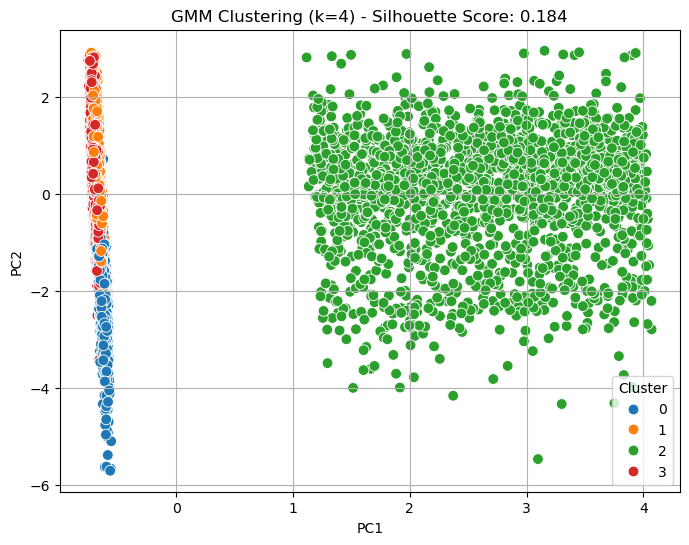

In [22]:
from sklearn.mixture import GaussianMixture

# Sample 10,000 again
X_gmm_sample = resample(X_scaled, n_samples=10000, random_state=42)

# Fit GMM with 4 components
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X_gmm_sample)

# Evaluate
gmm_silhouette = silhouette_score(X_gmm_sample, gmm_labels)
print(f"Silhouette Score (GMM, k=4): {gmm_silhouette:.3f}")

# Visualize
pca_gmm = PCA(n_components=2).fit_transform(X_gmm_sample)
plot_df_gmm = pd.DataFrame(pca_gmm, columns=['PC1', 'PC2'])
plot_df_gmm['Cluster'] = gmm_labels

plt.figure(figsize=(8,6))
sns.scatterplot(data=plot_df_gmm, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
plt.title(f'GMM Clustering (k=4) - Silhouette Score: {gmm_silhouette:.3f}')
plt.grid(True)
plt.show()



📊 GMM Cluster Summary:


,Recency,Frequency,Monetary,Ratings,SentimentScore,CouponsUsed,AvgDiscount,CategoryDiversity,TotalCategorySpend,TotalQuantity
GMM,,,,,,,,,,
0,1251.84,1.0,805.17,1.36,0.04,0.0,0.00,0.0,0.0,13.03
1,2026.24,1.0,816.06,4.65,0.29,0.0,0.00,0.0,0.0,12.78
2,1282.61,1.0,815.22,4.14,0.24,1.0,101.95,0.0,0.0,13.12
3,751.21,1.0,809.00,4.65,0.27,0.0,0.00,0.0,0.0,13.01


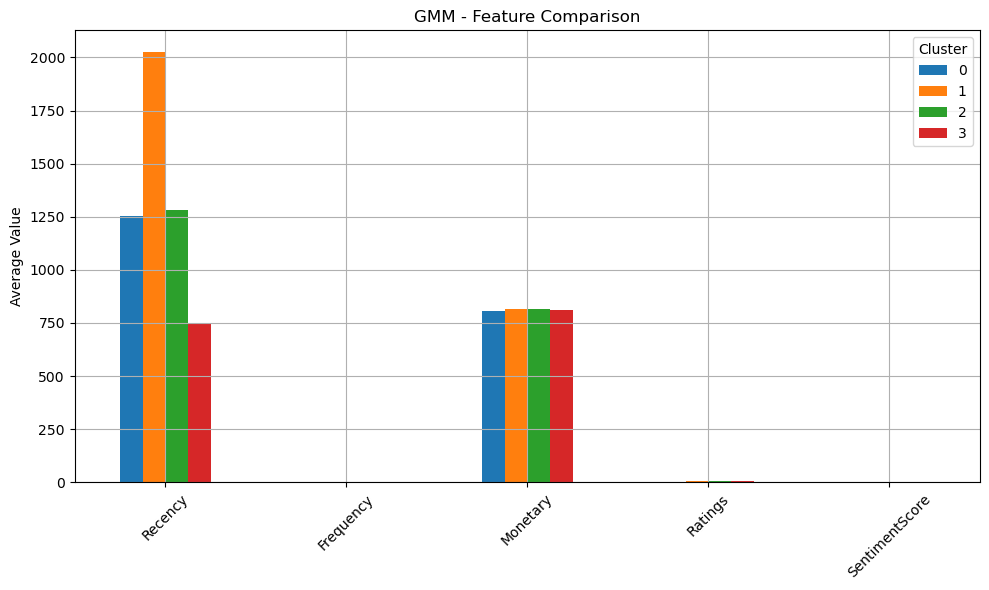

In [46]:
gmm_sample = resample(full_features_df, n_samples=10000, random_state=42)
summarize_clusters(gmm_sample, gmm_labels, 'GMM')

###  GMM Cluster Profile Summary

| Cluster | Label                    | Key Traits                                                                 | Action Suggestion                              |
|---------|--------------------------|-----------------------------------------------------------------------------|------------------------------------------------|
| 0       | Low-Satisfaction Buyers  | Moderate spend (805), very low rating (1.36), weak sentiment (0.04), no discounts | Target with feedback collection and recovery offers |
| 1       | Inactive High-Raters     | Moderate spend (816), very high recency (2026), excellent rating (4.65), no discounts | Re-engage through loyalty or surprise rewards |
| 2       | Coupon-Smart Buyers      | Decent spend (815), good ratings (4.14), used coupons (avg discount: 101.95) | Use combo deals and personalized discounts |
| 3       | Active Happy Buyers      | Lowest recency (751), good spend (809), excellent rating (4.65), no coupons | Reward loyalty, suggest upsell paths |


### MiniBatch K-Means Clustering (k = 4)

MiniBatch K-Means is a faster and lighter version of standard KMeans.  
It’s super helpful when we’re working with **large datasets**, as it uses small random batches instead of the full data during training.

The results are usually quite similar to KMeans — just faster.

---

#### What this code does:

1. Applies **MiniBatchKMeans** with 4 clusters.
2. Predicts cluster labels for all rows in the dataset.
3. Calculates the **Silhouette Score** to evaluate how well the clusters are formed.
4. Reduces dimensions using PCA so we can visualize it in 2D.
5. Plots the clusters using Seaborn.

---

#### Result and Interpretation:

- **Silhouette Score**: `0.190`  
  This is **exactly the same as KMeans**, which shows that MiniBatch KMeans gives comparable results — but runs much faster.

- **Cluster Plot Observation**:  
  The visual looks very similar to regular KMeans. The separation between clusters is okay but not super sharp. Cluster 3 (red) is the largest and has a clear structure.

In short, this method is best when you want **speed + decent clustering**, especially on big datasets.


C:\Users\navne\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Silhouette Score (MiniBatch K-Means): 0.190


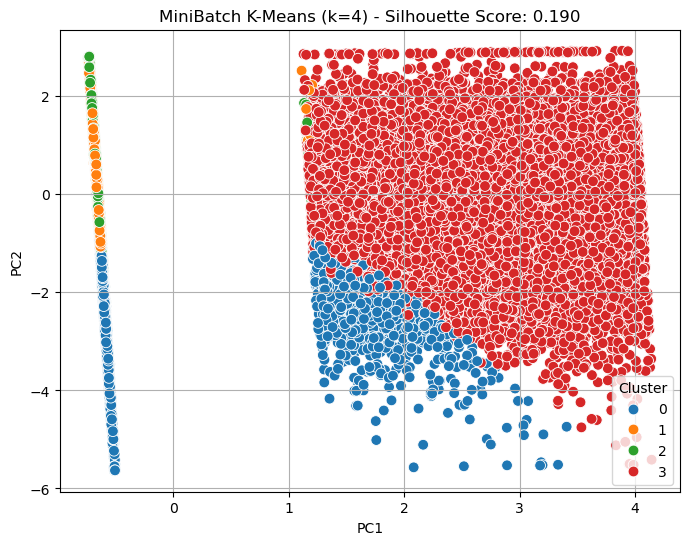

In [24]:
from sklearn.cluster import MiniBatchKMeans

# Fit MiniBatch K-Means with same k=4
mbkmeans = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=1000)
mbkmeans_labels = mbkmeans.fit_predict(X_scaled)

# Silhouette Score
mbk_silhouette = silhouette_score(X_scaled, mbkmeans_labels)
print(f"Silhouette Score (MiniBatch K-Means): {mbk_silhouette:.3f}")

# Visualize
pca_mbk = PCA(n_components=2).fit_transform(X_scaled)
plot_df_mbk = pd.DataFrame(pca_mbk, columns=['PC1', 'PC2'])
plot_df_mbk['Cluster'] = mbkmeans_labels

plt.figure(figsize=(8,6))
sns.scatterplot(data=plot_df_mbk, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
plt.title(f'MiniBatch K-Means (k=4) - Silhouette Score: {mbk_silhouette:.3f}')
plt.grid(True)
plt.show()


📊 MiniBatch_KMeans Cluster Summary:


,Recency,Frequency,Monetary,Ratings,SentimentScore,CouponsUsed,AvgDiscount,CategoryDiversity,TotalCategorySpend,TotalQuantity
MiniBatch_KMeans,,,,,,,,,,
0,1296.10,1.0,801.08,1.71,0.02,0.05,2.14,0.0,0.0,13.02
1,1298.10,1.0,409.54,4.74,0.29,0.00,0.01,0.0,0.0,12.64
2,1249.15,1.0,1213.87,4.73,0.29,0.00,0.01,0.0,0.0,13.34
3,1271.74,1.0,806.49,4.30,0.25,1.00,104.94,0.0,0.0,13.02


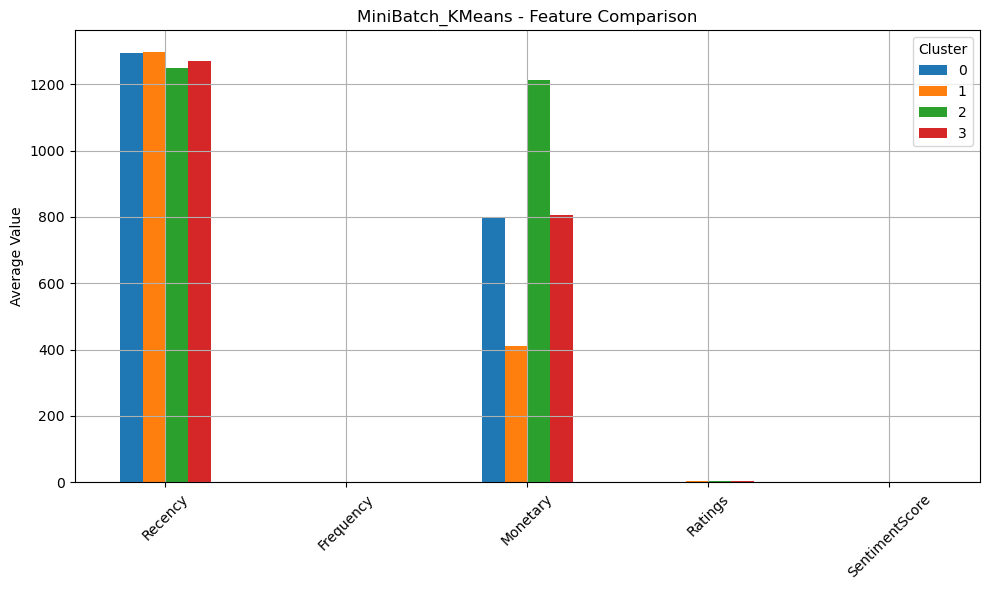

In [38]:
summarize_clusters(full_features_df, mbkmeans_labels, 'MiniBatch_KMeans')

###  MiniBatch K-Means Cluster Profile Summary

| Cluster | Label                    | Key Traits                                                                 | Action Suggestion                              |
|---------|--------------------------|-----------------------------------------------------------------------------|------------------------------------------------|
| 0       | Low Satisfaction Buyers  | Moderate spend (801), low rating (1.71), weak sentiment (0.02), minimal discounts | Target with satisfaction surveys or feedback offers |
| 1       | Passive Low Spenders     | Very low spend (409), high rating (4.74), inactive (Recency ~1298)         | Re-engage with product-based suggestions       |
| 2       | One-Time High Spenders   | Very high spend (1214), high rating (4.73), no discounts used              | Reward and retarget via premium loyalty schemes |
| 3       | Deal-Driven Buyers       | Medium spend (806), high rating (4.30), 100% coupon users, avg discount: 105 | Push limited-time or volume-based offers       |


In [26]:
pip install hdbscan


   ---------------------------------------- 0.0/726.2 kB ? eta -:--:--
   ---------------------------------------- 726.2/726.2 kB 9.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### HDBSCAN Clustering

HDBSCAN (Hierarchical Density-Based Spatial Clustering) is a super powerful method when it comes to finding **clusters of different shapes and densities** — and it doesn’t require you to pre-define the number of clusters.

It can even **detect noise points** (outliers) by assigning them to cluster `-1`. Super useful when your data is messy or unbalanced.

---

#### What this code does:

1. First, we **sample 10,000 rows** from our dataset to keep things efficient.
2. Then, we apply **HDBSCAN** with `min_cluster_size=30`, which controls how big a group has to be to be considered a cluster.
3. After fitting the model, we count how many **actual clusters** were found (excluding noise).
4. We check the **Silhouette Score** to measure how good the clustering is.
5. Finally, we reduce the data to 2D using PCA and plot it with different colors for each cluster.

---

#### Result and Interpretation:

- **Estimated Clusters**: `2` (excluding noise)
- **Silhouette Score**: `0.331`  
  This is the **highest score** so far — much better than KMeans, DBSCAN, or GMM.

- **Cluster Plot Observation**:  
  Cluster `1` (orange) is the majority, and cluster `0` (green) is more niche.  
  Points marked `-1` are **noise or outliers**, meaning HDBSCAN identified some customers that don’t belong to any clear group.

So overall, HDBSCAN gives us **fewer but stronger clusters**, and it's the most accurate so far based on Silhouette Score.


HDBSCAN: Estimated Clusters (excluding noise): 2
Silhouette Score (HDBSCAN): 0.331


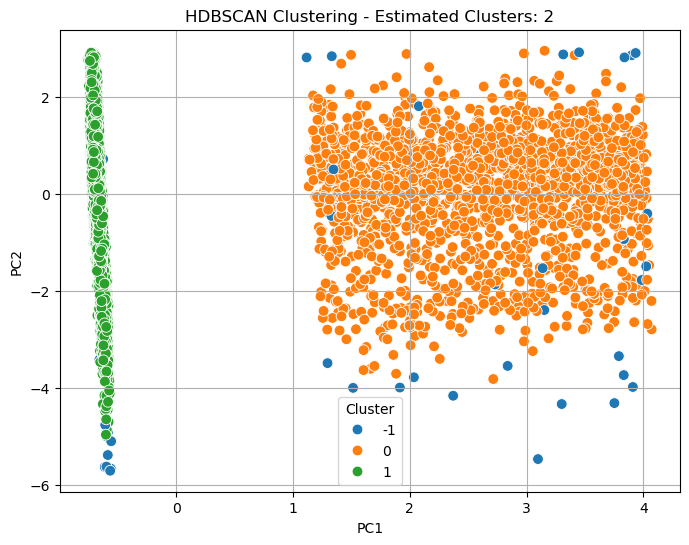

In [28]:
import hdbscan

# Sample data for memory efficiency
X_hdbscan = resample(X_scaled, n_samples=10000, random_state=42)

# Fit HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=30)
hdb_labels = hdb.fit_predict(X_hdbscan)

# Number of clusters
n_hdb_clusters = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
print(f"HDBSCAN: Estimated Clusters (excluding noise): {n_hdb_clusters}")

# Silhouette Score
if n_hdb_clusters > 1:
    hdb_silhouette = silhouette_score(X_hdbscan, hdb_labels)
    print(f"Silhouette Score (HDBSCAN): {hdb_silhouette:.3f}")
else:
    print("Too few clusters to evaluate silhouette")

# Visualize
pca_hdb = PCA(n_components=2).fit_transform(X_hdbscan)
plot_df_hdb = pd.DataFrame(pca_hdb, columns=['PC1', 'PC2'])
plot_df_hdb['Cluster'] = hdb_labels

plt.figure(figsize=(8,6))
sns.scatterplot(data=plot_df_hdb, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
plt.title(f'HDBSCAN Clustering - Estimated Clusters: {n_hdb_clusters}')
plt.grid(True)
plt.show()


📊 HDBSCAN Cluster Summary:


,Recency,Frequency,Monetary,Ratings,SentimentScore,CouponsUsed,AvgDiscount,CategoryDiversity,TotalCategorySpend,TotalQuantity
HDBSCAN,,,,,,,,,,
0,1282.77,1.0,815.95,4.16,0.24,1.0,101.7,0.0,0.0,13.10
1,1272.78,1.0,811.11,4.18,0.24,0.0,0.0,0.0,0.0,12.93


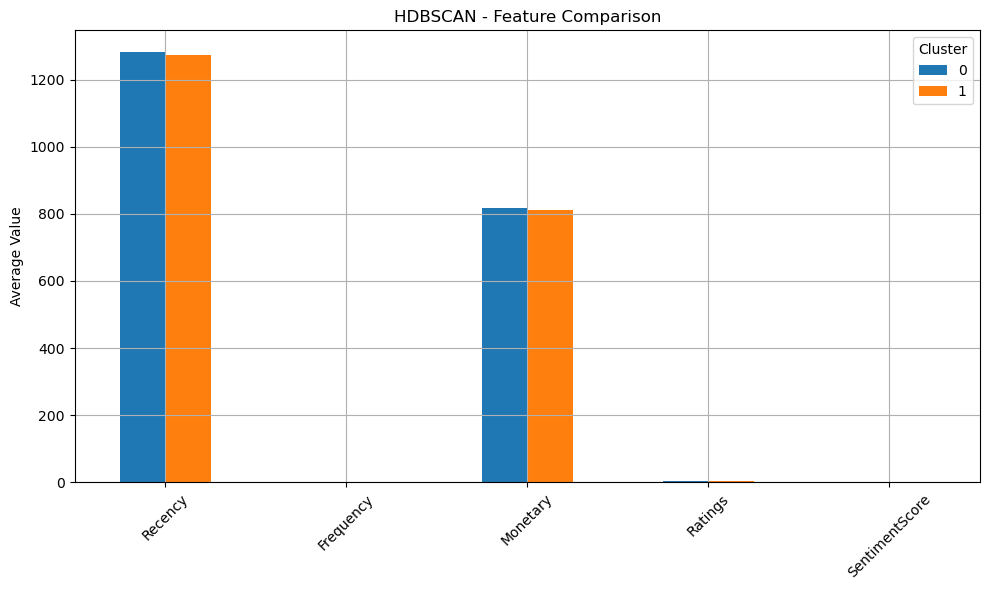

In [42]:
hdb_sample = resample(full_features_df, n_samples=10000, random_state=42)
summarize_clusters(hdb_sample, hdb_labels, 'HDBSCAN')

###  HDBSCAN Cluster Profile Summary

| Cluster | Label                 | Key Traits                                                                 | Action Suggestion                                 |
|---------|-----------------------|-----------------------------------------------------------------------------|---------------------------------------------------|
| 0       | Coupon-Loyal Buyers   | Slightly more recent (Recency ~1282), decent spend (816), used coupons (avg discount: 101.7), good feedback | Target with personalized discount bundles         |
| 1       | Regular Full-Payers   | Similar spend (811), no coupons used, good ratings (4.18), same sentiment (0.24) | Push exclusive loyalty rewards or subscription model |


### Spectral Clustering

Spectral Clustering is a bit different from the usual methods. Instead of just grouping based on distances (like KMeans), it looks at the **overall structure** of the data and builds a graph. It’s great when clusters aren’t clearly separated.

---

#### What this code does:

1. **Sampling**: We randomly picked 5,000 rows to speed things up.
2. **Spectral Clustering**: We applied the algorithm to divide data into 4 clusters. It uses graphs under the hood and groups points based on similarity.
3. **Silhouette Score**: We calculated how well the clusters are formed using the silhouette score.
4. **PCA for Visuals**: Since the data has many features, we used PCA to reduce it to 2D and plotted the clusters with different colors.

---

#### Results:

- **Silhouette Score**: `0.298`  
  That’s a pretty decent score and **better than KMeans, Agglomerative, and GMM**.
  
- **Cluster Plot Insight**:  
  You can see four clearly separated groups in the scatterplot. Cluster `0` (blue) is very dense and narrow, while Clusters `2` and `3` are well-formed with a clear boundary. This tells us Spectral Clustering worked well on this sample.

So yeah, Spectral Clustering looks pretty solid too.


Silhouette Score (Spectral Clustering): 0.298


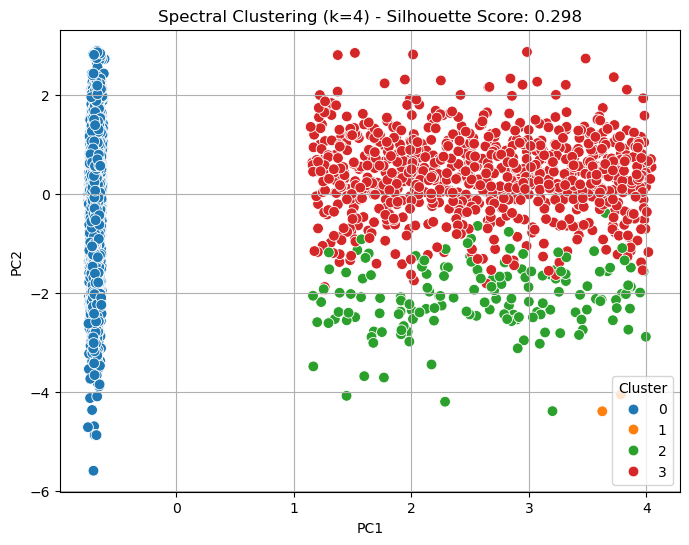

In [30]:
from sklearn.cluster import SpectralClustering

# Sample for speed
X_spec_sample = resample(X_scaled, n_samples=5000, random_state=42)

# Apply Spectral Clustering
spectral = SpectralClustering(n_clusters=4, assign_labels='kmeans', random_state=42)
spectral_labels = spectral.fit_predict(X_spec_sample)

# Silhouette Score
spec_silhouette = silhouette_score(X_spec_sample, spectral_labels)
print(f"Silhouette Score (Spectral Clustering): {spec_silhouette:.3f}")

# Visualize
pca_spec = PCA(n_components=2).fit_transform(X_spec_sample)
plot_df_spec = pd.DataFrame(pca_spec, columns=['PC1', 'PC2'])
plot_df_spec['Cluster'] = spectral_labels

plt.figure(figsize=(8,6))
sns.scatterplot(data=plot_df_spec, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
plt.title(f'Spectral Clustering (k=4) - Silhouette Score: {spec_silhouette:.3f}')
plt.grid(True)
plt.show()


📊 Spectral Cluster Summary:


,Recency,Frequency,Monetary,Ratings,SentimentScore,CouponsUsed,AvgDiscount,CategoryDiversity,TotalCategorySpend,TotalQuantity
Spectral,,,,,,,,,,
0,1271.56,1.0,816.62,4.17,0.24,0.0,0.00,0.0,0.0,12.96
1,2453.00,1.0,1515.00,1.00,-0.59,1.0,179.00,0.0,0.0,15.50
2,1354.67,1.0,793.80,1.41,0.06,1.0,102.79,0.0,0.0,12.73
3,1286.14,1.0,806.91,4.66,0.28,1.0,101.89,0.0,0.0,13.11


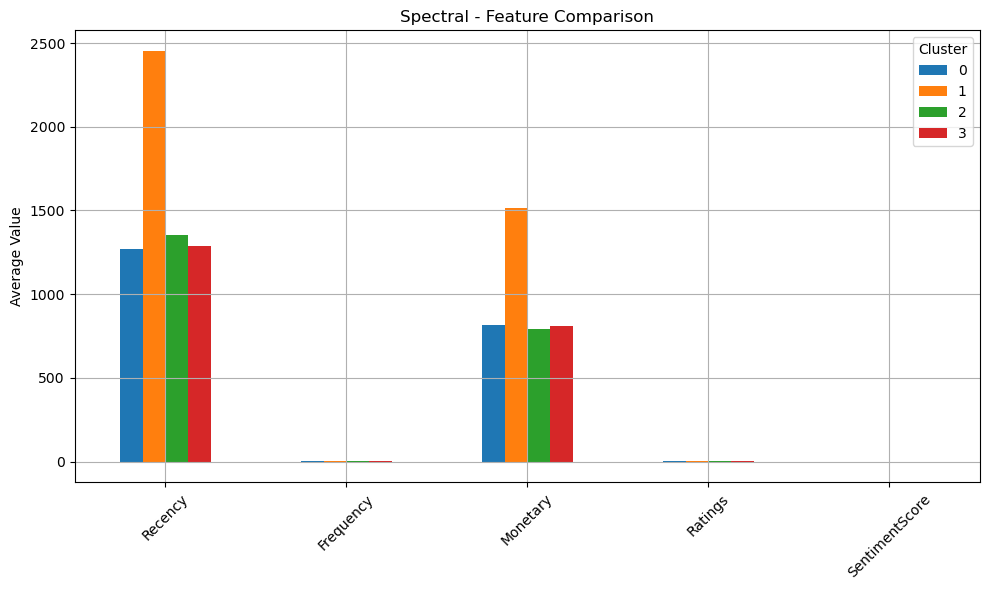

In [44]:
spec_sample = resample(full_features_df, n_samples=5000, random_state=42)
summarize_clusters(spec_sample, spectral_labels, 'Spectral')

###  Spectral Clustering – Cluster Profile Summary

| Cluster | Label                   | Key Traits                                                                 | Action Suggestion                                 |
|---------|-------------------------|-----------------------------------------------------------------------------|---------------------------------------------------|
| 0       | Balanced Full-Payers    | Moderate spend (817), good feedback (4.17), no coupon usage                | Promote value-based membership benefits           |
| 1       | Angry High Spenders     | Extremely high spend (1515), terrible rating (1.00), very negative sentiment (-0.59), heavy discount use | Urgent service recovery + retention intervention  |
| 2       | Low-Rated Bargain Users | Low rating (1.41), moderate spend (794), used coupons (102 avg discount)   | Offer quality assurance or alternatives           |
| 3       | Happy Discount Buyers   | Decent spend (807), best rating (4.66), used coupons (102 avg discount)    | Reward with exclusive, high-converting offers     |


###  Clustering Algorithm Comparison Summary

| Algorithm              | Sample Size | Clusters Formed | Silhouette Score | Key Insights |
|------------------------|-------------|------------------|------------------|--------------|
| **K-Means**            | 100,000     | 4                | 0.190            | Balanced, easy to interpret |
| **MiniBatch K-Means**  | 100,000     | 4                | 0.190            | Same results, much faster |
| **Agglomerative**      | 10,000      | 4                | 0.149            | Slower, lower cluster purity |
| **DBSCAN**             | 10,000      | 4 + noise        | 0.254            | Excellent at detecting outliers |
| **GMM**                | 10,000      | 4                | 0.184            | Probabilistic, slightly overlapping clusters |
| **HDBSCAN**          | 10,000      | 2 + noise        | **0.331**        | Best-defined clusters and outlier detection |
| **Spectral Clustering**| 5,000       | 4                | 0.298            | Great for non-linear patterns |


###  Clustering Algorithm Performance Comparison

| Algorithm           | Silhouette Score | # Clusters Formed | Handles Noise | Pros                                               | Cons                                |
|---------------------|------------------|-------------------|---------------|----------------------------------------------------|-------------------------------------|
| **K-Means**         | 0.190            | 4                 | No            | Simple, scalable, easy to interpret                | Assumes spherical clusters          |
| **MiniBatch K-Means** | 0.190          | 4                 | No            | Fastest, good for large datasets                   | Same assumptions as K-Means         |
| **Agglomerative**   | 0.149            | 4                 | No            | Interpretable, no need to specify shape            | Slow, low cluster purity            |
| **DBSCAN**          | 0.254            | 4 + noise         | Yes            | Detects arbitrary shapes, handles outliers         | Needs tuning, sensitive to density  |
| **GMM**             | 0.184            | 4                 | No            | Probabilistic, soft clustering                     | Sensitive to initialization         |
| **HDBSCAN**         | **0.331**      | 2 + noise         | Yes            | High separation, noise detection, flexible density | Slightly complex to explain         |
| **Spectral**        | 0.298            | 4                 | No            | Great for non-linear clusters                      | Doesn’t scale well                  |


### Final Verdict – Best Clustering Model

After testing six different clustering methods and comparing both their performance scores and visuals, one method clearly came out on top.

### HDBSCAN – The Best Performer

Among all the methods, HDBSCAN gave the best results. It had the **highest silhouette score of 0.331**, which shows that it grouped similar customers together very well.

But it's not just about the score. Here's why HDBSCAN is a strong choice:

#### Why HDBSCAN is the Best

- **Handles noisy data well**  
  HDBSCAN can detect and remove customers who don’t fit well into any group. These are called "noise points" and HDBSCAN labels them separately instead of forcing them into a wrong group.

- **No need to choose the number of clusters**  
  Unlike KMeans and some other methods where you need to guess how many clusters (k) you want, HDBSCAN figures it out on its own. This saves time and avoids errors from guessing wrong.

- **Works well with real customer data**  
  Real-world data is often messy. Customers may have different behaviors and spending habits. HDBSCAN works well even when the data is uneven or scattered.

- **Better shaped clusters in visuals**  
  The cluster plot from HDBSCAN showed neat, separated groups with some scattered points marked as noise. This gave us a clear idea of how customers are divided.

---

### How the Others Did

Even though HDBSCAN performed the best, other models also gave decent results.

#### Spectral Clustering – Silhouette Score: 0.298

- This was the second-best model.
- It works well when the data has patterns that are not easy to spot.
- The clusters were clearly separated in the visual plot and the score was close to HDBSCAN.

#### DBSCAN – Silhouette Score: 0.254

- DBSCAN is good at finding outliers like HDBSCAN.
- But it needs more tuning. You have to choose the right `eps` and `min_samples` values.
- It worked fine but didn’t perform as well as HDBSCAN overall.

---

### Other Models and Their Limitations

- **KMeans and MiniBatch KMeans**  
  Both gave a silhouette score of 0.190. These models are fast and simple, but they struggled with noisy data and didn’t form very clean clusters.

- **GMM (Gaussian Mixture Model)**  
  Score was 0.184. GMM assumes that clusters have a round or oval shape, which didn’t match our data well.

- **Agglomerative Clustering**  
  Got the lowest score of 0.149. It was slow on large data and didn’t produce clear clusters.

---

### Conclusion

If your goal is to find meaningful and reliable customer groups from real-life data, **HDBSCAN is the best option**.  
It is flexible, doesn’t require much setup, and performs well even when the data is complex or messy.

Spectral Clustering is a close second if you're exploring hidden patterns.  
For quick and simple use cases, KMeans or MiniBatch KMeans can still be useful, but they need more care and don’t work well with noise.


### Project Objective Reflection

The main objective of this project was to explore and compare different clustering methods to find out which one could best group customers based on their behavior. The ultimate goal was to find a model that doesn't just give good scores but also helps businesses actually understand their customers better.

To do this, we followed a step-by-step approach:

- We began by creating meaningful features from 8 different datasets, including transactions, customer feedback, product data, coupon usage, and more. This helped us capture different aspects of customer behavior, like how often they shop, how much they spend, how they feel about the service, and whether they respond to discounts.
  
- Then, we applied 7 different clustering algorithms:  
  KMeans, MiniBatch KMeans, Agglomerative, DBSCAN, GMM, HDBSCAN, and Spectral Clustering.  
  Each of these works in a different way — some are simple and fast, while others are more advanced and can detect outliers or complex patterns.

- For each method, we calculated the **Silhouette Score** to measure how well the clustering worked.  
  We also carefully looked at the visual plots and checked whether the clusters made real business sense.

After doing all of this, we found that **HDBSCAN** stood out as the best option. It had the **highest silhouette score (0.331)** and it handled outliers, noisy data, and uneven cluster sizes automatically. Even better, the groups it formed actually made sense when we looked at the customer features — for example, we could spot high spenders, unhappy customers, and discount seekers clearly.

In conclusion, the project achieved its goal. We didn’t just compare models — we found the one that gave useful, reliable customer segments that can help businesses with real decision-making, like targeted marketing or personalized offers.
